In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import tensorflow as tf
import keras
from keras import optimizers, Sequential
from keras.models import Model
#from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from numpy import arange, sin, pi, random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.integrate as integrate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from scipy.stats import pearsonr

np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

#Import Data


In [3]:
data = np.load('/content/drive/MyDrive/Datasets/scada1.npz')
lst = data.files
# for item in lst:
#     print(item)
#     print(data[item])
X_train = data['training']
X_test = data['test']
idx_anomaly_test = data['idx_anomaly_test']
normal_test_data = X_test[~idx_anomaly_test]
anomalous_test_data = X_test[idx_anomaly_test]
test_index = data['idx_anomaly_test']
#print(X_test.shape)
y_test = [1]*len(data['t_test'])
for i in test_index:
  y_test[i-1] = -1
#print(y_test)
#Split X_train and X_test according to the ratio of 80:20
X_train = X_train[0:40192]
X_test = X_test[0:10048]
y_test = y_test[0:10048]
#Reshape the input data to fit LSTM model
X_train = np.reshape(X_train, (2512,16,16))
X_test = np.reshape(X_test, (628,16,16))
sequence_length =16
DATA_SPLIT_PCT = 0.2
SEED = 123 #used to help randomly select the data points
batch_size = 50
epochs = 30
X_train_X, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
timesteps =  16 # equal to the sequence_length
n_features =  16
print(X_train_X.shape)
print(X_valid.shape)

(2009, 16, 16)
(503, 16, 16)


#LSTM Model

In [4]:
%%time
results = {}
for num_cells in [64]:
    for lr in [1e-3]:
            print('Running with', num_cells,
                  'LSTM cells'
                  'and learning rate =', lr, '...')

            # build network
            lstm_autoencoder = Sequential()
            # Encoder
            lstm_autoencoder.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
            lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=False))
            lstm_autoencoder.add(RepeatVector(timesteps))
            # Decoder
            lstm_autoencoder.add(LSTM(25, activation='relu', return_sequences=True))
            lstm_autoencoder.add(LSTM(100, activation='relu', return_sequences=True))
            lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
            # lstm_autoencoder.add(tf.keras.layers.Flatten())
            lstm_autoencoder.summary()
            adam = tf.optimizers.Adam(lr)
            lstm_autoencoder.compile(loss='mse', optimizer=adam)
            cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
            tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
            lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train,
                                                epochs=epochs,
                                                batch_size=batch_size,
                                                validation_data=(X_valid, X_valid),
                                                verbose=2, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
            print("Predicting...")
            predicted_train = lstm_autoencoder.predict(X_train)
            predicted = lstm_autoencoder.predict(X_test)

Running with 64 LSTM cellsand learning rate = 0.001 ...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 100)           46800     
                                                                 
 lstm_1 (LSTM)               (None, 25)                12600     
                                                                 
 repeat_vector (RepeatVecto  (None, 16, 25)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 16, 25)            5100      
                                                                 
 lstm_3 (LSTM)               (None, 16, 100)           50400     
                                                                 
 time_distributed (TimeDist  (None, 16, 16)            1616      
 ributed)                                               

#Anomaly Detection using OCSVM

In [5]:
e = X_train - predicted_train
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples*nx,ny))
X_train1 = d2_e
X_test1 = X_test.reshape(10048,16)
from sklearn.svm import OneClassSVM
#model = OneClassSVM(kernel = 'rbf', gamma = 0.07, nu = 0.003).fit(X_train1)
model = OneClassSVM(kernel = 'rbf', gamma = 0.01, nu = 0.015).fit(X_train1)
##{'gamma': 0.001, 'kernel': 'rbf', 'nu': 0.001}
y_predict = model.predict(X_test1)
precision = precision_score(y_test, y_predict)
recall    = recall_score(y_test, y_predict)
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
print ('Accuracy : ', accuracy)
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('F1_score: ', f1)

Accuracy :  0.7060111464968153
Precision :  0.8402834559825566
Recall:  0.7757926522395571
F1_score:  0.8067512756770902


##Anomaly Detection using IF

In [6]:
rng = np.random.RandomState(500)
clf = IsolationForest(max_samples=40002, random_state=rng)
#from sklearn.covariance import EllipticEnvelope
#clf = EllipticEnvelope(contamination=0.01)
clf.fit(X_train1)
y_predict = clf.predict(X_test1)
precision = precision_score(y_test, y_predict)
recall    = recall_score(y_test, y_predict)
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
print ('Accuracy : ', accuracy)
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('F1_score: ', f1)

Accuracy :  0.6009156050955414
Precision :  0.8572206095791002
Recall:  0.594489179667841
F1_score:  0.7020802377414561


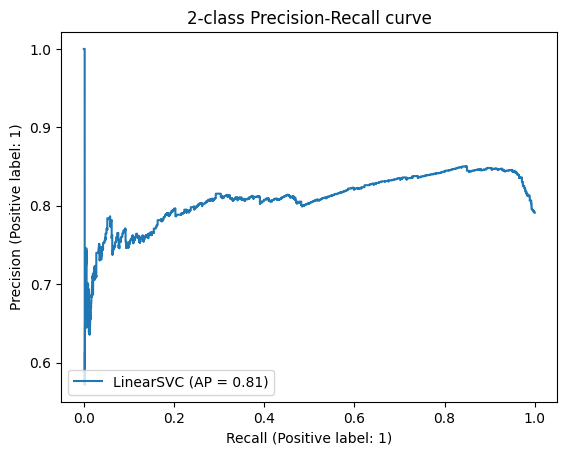

In [7]:
from sklearn.metrics import PrecisionRecallDisplay
y_score = model.decision_function(X_test1)
display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [8]:
# for i in range(1,10):
#   for j in range(1,9):
#     model = OneClassSVM(kernel = 'rbf',degree = j, gamma = 0.001*i, nu = 0.002*i).fit(X_train1)
#     y_predict = model.predict(X_test1)
#     f1 = f1_score(y_test, y_predict)
#     print ('F1_score: ', f1)

In [9]:
# predicted_train = lstm_autoencoder.predict(X_train)
# predicted = lstm_autoencoder.predict(X_test)
# mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)
# mse_train = np.mean(np.power(flatten(X_train) - flatten(predicted_train), 2), axis=1)
# params = {'bandwidth': np.linspace(0, 0.5, 10)}
# grid = GridSearchCV(KernelDensity(), params, cv = 20)
# grid.fit(mse_train[:, None])
# h=grid.best_estimator_.bandwidth2
# tau=FindThreshold(mse_train,h,0.56)

#Model Explantation

In [10]:
lstm_autoencoder1 = Sequential()
# Encoder
lstm_autoencoder1.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder1.add(LSTM(25, activation='relu', return_sequences=False))
lstm_autoencoder1.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder1.add(LSTM(25, activation='relu', return_sequences=True))
lstm_autoencoder1.add(LSTM(100, activation='relu', return_sequences=True))
lstm_autoencoder1.add(TimeDistributed(Dense(n_features)))
lstm_autoencoder1.add(tf.keras.layers.Flatten())
lstm_autoencoder1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 16, 100)           46800     
                                                                 
 lstm_5 (LSTM)               (None, 25)                12600     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 16, 25)            0         
 tor)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 16, 25)            5100      
                                                                 
 lstm_7 (LSTM)               (None, 16, 100)           50400     
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 16)            1616      
 stributed)                                           

In [11]:
#transfer model
lstm_autoencoder1.layers[0].set_weights(lstm_autoencoder.layers[0].get_weights())
lstm_autoencoder1.layers[1].set_weights(lstm_autoencoder.layers[1].get_weights())
lstm_autoencoder1.layers[2].set_weights(lstm_autoencoder.layers[2].get_weights())
lstm_autoencoder1.layers[3].set_weights(lstm_autoencoder.layers[3].get_weights())
lstm_autoencoder1.layers[4].set_weights(lstm_autoencoder.layers[4].get_weights())
lstm_autoencoder1.layers[5].set_weights(lstm_autoencoder.layers[5].get_weights())
predicted_train1 = lstm_autoencoder1.predict(X_train)
# print(predicted_train1)

79/79 [==============================] - 1s 12ms/step


In [12]:
!pip  install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.7 MB/s eta 0:00:00


In [ ]:
import shap
# X_train2 = X_train[0:400]
X_train2 = X_train[:]
explainer = shap.GradientExplainer(lstm_autoencoder1, X_train2)
X_test_2 = X_test[0:16]
shap_values  = explainer.shap_values(X_test_2)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [ ]:
shap.initjs()

In [ ]:
import pandas as pd
features = ['address','function','length','setpoint','gain','reset rate','deadband','cycle time','rate','system mode','control scheme','pump','solenoid','pressure measurement','crc rate','command reponse']
shap_values_2D = shap_values[0].reshape(-1,16)
X_test_2D = X_test_2.reshape(-1,16)
x_test_2d = pd.DataFrame(data=X_test_2D, columns = features)
# x_test_2d.corr()
shap.summary_plot(shap_values_2D, x_test_2d)